In [1]:
import json
from pymongo import MongoClient
import pandas as pd
import gensim
from gensim.models import phrases
from gensim.utils import lemmatize
import en_core_web_sm
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from sklearn.externals import joblib
import spacy
import re
import string

# Assigning score to sentences in abstracts

Assign score to sentences based on following features:

* Length of sentence
* Number of Named Entities
* Number of top K-important words (see keyword extraction)
* Sentence position in the doc: sentences in introductions and summaries are more likely to be relevant. The problem is that after conversion, the docs do not have much of a structure, they are basically a huge string. It should be possible to recover some structure based on number of white lines and words such as 'section', 'chapter', '1.' etc.
* Number of Upper Case words: often special terminology or names
* Number of nouns, verbs and adjectives (lexical semantics)  

Normalization:

* sentence position to %
* other features: sigmoid function  

Classification to optimize weights of the features:

Train logistic regression model based on sentences in abstracts (1) and sentences in examples (0)
Retain the optimal parameters to calculate sentence scores.

In [196]:
client = MongoClient()
db = client.lingbuzz
papers = db.get_collection('papers')

In [3]:
abstracts = []
for doc in papers.find({'abstract':{'$exists': True}}):
    abstracts+=doc['abstract']

In [4]:
nlp = spacy.load('en_core_web_sm')

In [5]:
top_k_words = joblib.load('top_k_words')

In [6]:
authors = joblib.load('authors')

In [7]:
def count_k_important(sent):
    count = 0
    for w in sent:
        if w.lower_ in top_k_words:
            count+=1
    return count

def eliminate_non_english_words(s):
    """takes list of words and eliminates all words that contain non-english characters, digits or punctuation"""
    english_words = []
    for word in s:
        if word.lower() in authors:
            english_words.append(word)
        else: 
            try:
                word.encode(encoding='utf-8').decode('ascii')
                # if re.sub('-', '', word).isalpha():
                    # english_words.append(re.sub('[%s]' % re.escape(string.punctuation), '', word))
                word = re.sub('[%s]' % re.escape(string.punctuation), '', word)
                if word.isalpha():
                    english_words.append(word) 
            except UnicodeDecodeError:
                pass
    return ' '.join(english_words)

def calculate_named_entities(sent):
    count = 0
    entities = []
    for ent in sent.ents:
        count+=1
        entities.append((ent.label_, ent.text))
    return count, entities

def calculate_pos(sent):
    n = 0
    v = 0
    a = 0
    for w in sent:
        if w.pos_ == 'VERB':
            v+=1
        if w.pos_ == 'ADJ':
            a += 1
        if w.pos_ == 'NOUN':
            n+=1
    return n, v, a

def calculate_upper(sent):
    counter = -1
    for w in sent:
        if not w.is_lower:
            counter += 1
    return counter    

In [92]:
def calculate_features(li):
    """takes a list of texts and returns df with sentences and their features"""
    all_sentences = []
    for a in li:
        posi = 0
        for sent in nlp(a).sents:
            out = [str(sent), len(list(sent))]
            upper = calculate_upper(sent)
            sent = nlp(eliminate_non_english_words(str(sent).split()))
            named_entities, _ = calculate_named_entities(sent)
            k_important = count_k_important(sent)
            pos = 100/len(list(nlp(a).sents))*posi
            nouns, verbs, adjectives = calculate_pos(sent)
            out+=[named_entities, k_important, pos, upper, nouns, verbs, adjectives]
            all_sentences.append(out)
            posi += 1
    features = pd.DataFrame(all_sentences, columns=['sentence', 'length', 'named_entities', 'k_important', 'position',
                                                    'upper', 'nouns', 'verbs', 'adjectives'])
    return features

In [93]:
features_df = calculate_features(abstracts)

In [94]:
features_df.head()

,sentence,length,named_entities,k_important,position,upper,nouns,verbs,adjectives
0,The paper will argue for the existence of null...,63,4,28,0.0,14,13,9,6
1,I will present a set of paradoxical cases in w...,32,1,13,20.0,4,8,4,3
2,I will suggest that the domain of locality rel...,29,3,15,40.0,4,4,5,4
3,"Specifically, it will be proposed that a resum...",31,3,12,60.0,13,3,6,1
4,The CCRC will explain why resumptive dependenc...,34,7,15,80.0,9,4,5,3


In [95]:
joblib.dump(features_df, 'abstracts_features')

['abstracts_features']

In [96]:
features_df.shape

(19181, 9)

In [97]:
features_df.describe()

,length,named_entities,k_important,position,upper,nouns,verbs,adjectives
count,19181.000000,19181.000000,19181.000000,19181.000000,19181.000000,19181.000000,19181.000000,19181.000000
mean,30.638392,1.087691,13.118398,41.640165,6.615453,6.412439,3.920963,3.274178
std,16.208470,1.302931,6.979667,28.872590,5.774714,3.783424,2.501618,2.454456
min,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,8.000000,16.666667,3.000000,4.000000,2.000000,2.000000
50%,28.000000,1.000000,12.000000,40.000000,5.000000,6.000000,4.000000,3.000000
75%,39.000000,2.000000,17.000000,66.666667,9.000000,8.000000,5.000000,5.000000
max,221.000000,14.000000,96.000000,99.137931,66.000000,47.000000,29.000000,37.000000


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([  267.,   629.,  1485.,  2323.,  2901.,  2827.,  2381.,  1877.,
         1363.,   945.,   696.,   473.,   295.,   234.,   148.,   105.,
           61.,    43.,    31.,    30.]),
 array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
          45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
          90.,   95.,  100.]),
 <a list of 20 Patch objects>)

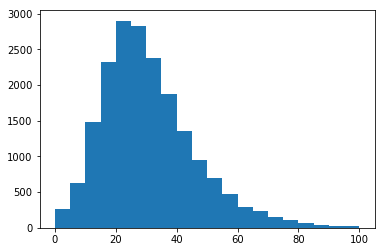

In [15]:
plt.hist(features_df.length, range = [0, 100], bins = 20 )

(array([  3.08000000e+02,   5.90000000e+02,   1.04900000e+03,
          1.79200000e+03,   2.41800000e+03,   2.59900000e+03,
          2.58400000e+03,   2.02200000e+03,   1.59700000e+03,
          1.26300000e+03,   9.23000000e+02,   6.15000000e+02,
          4.27000000e+02,   2.88000000e+02,   2.15000000e+02,
          1.51000000e+02,   9.00000000e+01,   6.30000000e+01,
          5.60000000e+01,   4.10000000e+01,   2.20000000e+01,
          1.50000000e+01,   1.00000000e+01,   8.00000000e+00,
          1.10000000e+01,   3.00000000e+00,   7.00000000e+00,
          4.00000000e+00,   6.00000000e+00,   1.00000000e+00]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.]),
 <a list of 30 Patch objects>)

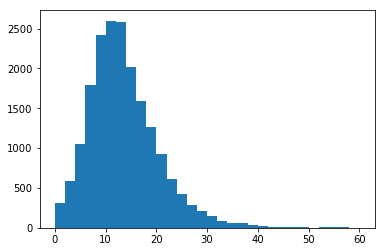

In [16]:
plt.hist(features_df.k_important, range = (0, 60), bins = 30 )

(array([  6.83000000e+02,   2.05500000e+03,   3.26000000e+03,
          3.49600000e+03,   3.11000000e+03,   2.38900000e+03,
          1.61100000e+03,   1.02500000e+03,   6.06000000e+02,
          3.80000000e+02,   2.13000000e+02,   1.17000000e+02,
          9.10000000e+01,   5.80000000e+01,   3.20000000e+01,
          2.00000000e+01,   1.00000000e+01,   9.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.]),
 <a list of 25 Patch objects>)

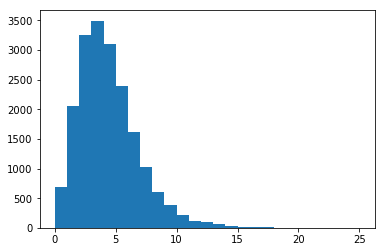

In [17]:
plt.hist(features_df.verbs, range = (0, 25), bins = 25 )

(array([  456.,   679.,  1168.,  1763.,  2256.,  2382.,  2309.,  1980.,
         1647.,  1222.,   901.,   697.,   493.,   339.,   238.,   188.,
          130.,    86.,    60.,    58.,    37.,    28.,    10.,    11.,
           14.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.]),
 <a list of 25 Patch objects>)

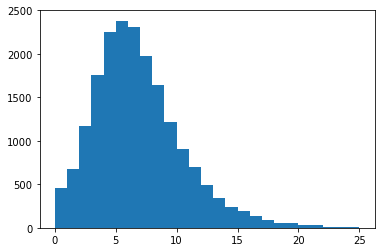

In [18]:
plt.hist(features_df.nouns, range = (0, 25), bins = 25 )

(array([ 3241.,   295.,   942.,   670.,   884.,  1271.,  1215.,   473.,
         1217.,   194.,  1685.,   704.,  1057.,  1121.,   622.,  1040.,
         1240.,   858.,   401.,    51.]),
 array([  0.        ,   4.95689655,   9.9137931 ,  14.87068966,
         19.82758621,  24.78448276,  29.74137931,  34.69827586,
         39.65517241,  44.61206897,  49.56896552,  54.52586207,
         59.48275862,  64.43965517,  69.39655172,  74.35344828,
         79.31034483,  84.26724138,  89.22413793,  94.18103448,  99.13793103]),
 <a list of 20 Patch objects>)

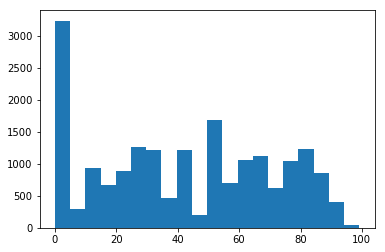

In [48]:
plt.hist(features_df.position, bins= 20)

In [185]:
df_trash_abstract = features_df.loc[(features_df.length <=5) | ((features_df.upper  <1) | (features_df.verbs == 0))]

df_trash_abstract.shape

(798, 9)

# Assigning score to non-relevant sentences:

It's a bit harder to automatically find non-relevant sentences. In the df that was made based on the abstratcs, there is a whole lot of sentences that aren't really sentences though. These are characterised as follows:
* no k-important words
* no nouns, verbs or adjectives (probably because we ar not dealing with English here). No adjectives is not a problem, no verb is, all sentences have verbs.
* very short sentences
* -1 upper case words (they aren't real sentences)

They have to be eliminated form the 'relevant sentence' class.

Possibility: eliminate sentences with these properties EXCEPT if they contain k-important words or named entities. These are likley to be trash.

For the irrelevant sentences: 
We could go based on the k_important words alone: if a sentence has no k_important words, it's an irrelevant one. But then in our classification model, number of k_important words will be the only necessary predictive feature, we don't want that. So we have to select irrelevant sentences that have variety in all of their features.

Idea: 
* select sentences containing non-English characters (likely to be examples)

In [21]:
# weird_sentences = []
# for doc in papers.find({'paper_raw':{'$exists': True}}):
#     paper = doc['paper']
#     l_p = len(list(nlp(paper)))
#     counter = 0
#     for sent in nlp(paper).sents:
#         try:
#             str(sent).encode(encoding='utf-8').decode('ascii')
#         except UnicodeDecodeError:
#             try: 
#                 weird_sentences.append((str(sent), counter/l_p))
#             except:
#                 pass
#         counter += 1

In [22]:
weird_sentences2 = []
for doc in papers.find({'paper':{'$exists': True}}):
    paper = doc['paper']
    l_p = len(list(nlp(paper).sents))
    counter = 0
    for sent in nlp(paper).sents:
        try:
            str(sent).encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError:
            try: 
                weird_sentences2.append((str(sent), 100/l_p*counter))
            except:
                pass
        counter += 1

In [23]:
len(weird_sentences2)

248310

In [24]:
d = pd.DataFrame(weird_sentences2)

In [25]:
d.head()

,0,1
0,ANALYTIC PASSIVES IN CZECH Ludmila Veselovs...,0.000000
1,(1) (b) Pavel je chválen Petrem Paul ...,0.216763
2,(2) (a) Morphology: (i) (ii) (iii) ...,0.505780
3,A related functional generative linguists (Enc...,0.794798
4,"On the other hand, the proponents of the mul...",0.867052


In [26]:
joblib.dump(d, 'weird_sentences')

['weird_sentences']

In [27]:
joblib.dump(weird_sentences2, 'weird_sentences_list')

['weird_sentences_list']

In [28]:
for sent, pos in weird_sentences2[:3]:
    print(type(sent), pos)

<class 'str'> 0.0
<class 'str'> 0.21676300578034685
<class 'str'> 0.5057803468208093


In [154]:
all_weird_sentences = []
for sent, pos in weird_sentences2:
    out = [sent, len(list(nlp(sent)))]
    upper = calculate_upper(nlp(sent))
    sent = nlp(eliminate_non_english_words(sent.split()))
    named_entities, _ = calculate_named_entities(sent)
    k_important = count_k_important(sent)
    nouns, verbs, adjectives = calculate_pos(sent)
    out+=[named_entities, k_important, pos, upper, nouns, verbs, adjectives]
    all_weird_sentences.append(out)

In [155]:
weird_df = pd.DataFrame(all_weird_sentences, columns=['sentence', 'length', 'named_entities', 'k_important', 'position', 
                                                'upper', 'nouns', 'verbs', 'adjectives'])

In [156]:
# select about 20 000 sentences for the irrelevant category
weird_df.head()

,sentence,length,named_entities,k_important,position,upper,nouns,verbs,adjectives
0,ANALYTIC PASSIVES IN CZECH Ludmila Veselovs...,39,1,18,0.000000,21,6,4,3
1,(1) (b) Pavel je chválen Petrem Paul ...,69,4,17,0.216763,34,5,8,3
2,(2) (a) Morphology: (i) (ii) (iii) ...,170,5,35,0.505780,79,17,13,16
3,A related functional generative linguists (Enc...,57,2,16,0.794798,22,11,2,6
4,"On the other hand, the proponents of the mul...",70,2,23,0.867052,23,13,6,9


In [157]:
joblib.dump(weird_df, 'weird_df')

['weird_df']

In [158]:
weird_df.describe()

,length,named_entities,k_important,position,upper,nouns,verbs,adjectives
count,248310.000000,248310.000000,248310.000000,248310.000000,248310.000000,248310.000000,248310.000000,248310.000000
mean,36.573247,1.117442,8.949966,46.774805,16.451472,4.887411,3.043941,1.884330
std,59.846245,1.641570,8.910641,26.877643,47.917929,5.425601,3.404920,2.419124
min,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,14.000000,0.000000,3.000000,24.441378,5.000000,1.000000,0.000000,0.000000
50%,28.000000,1.000000,7.000000,45.521136,10.000000,4.000000,2.000000,1.000000
75%,48.000000,2.000000,13.000000,67.996897,20.000000,7.000000,5.000000,3.000000
max,17752.000000,76.000000,453.000000,100.106213,17630.000000,415.000000,112.000000,106.000000


In [118]:
weird_df[weird_df.length == 12477.000000]

,sentence,length,named_entities,k_important,position,upper,nouns,verbs,adjectives
143395, ...,12477,3,11,33.333333,17630,2,0,2


In [119]:
features_df.describe()

,length,named_entities,k_important,position,upper,nouns,verbs,adjectives
count,19181.000000,19181.000000,19181.000000,19181.000000,19181.000000,19181.000000,19181.000000,19181.000000
mean,30.638392,1.087691,13.118398,41.640165,6.615453,6.412439,3.920963,3.274178
std,16.208470,1.302931,6.979667,28.872590,5.774714,3.783424,2.501618,2.454456
min,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,8.000000,16.666667,3.000000,4.000000,2.000000,2.000000
50%,28.000000,1.000000,12.000000,40.000000,5.000000,6.000000,4.000000,3.000000
75%,39.000000,2.000000,17.000000,66.666667,9.000000,8.000000,5.000000,5.000000
max,221.000000,14.000000,96.000000,99.137931,66.000000,47.000000,29.000000,37.000000


In [120]:
features_df[features_df.length == 221]['sentence']

4173    I provide a substantial and systematic descrip...
Name: sentence, dtype: object

In [177]:
df_trash_weird = weird_df.loc[(weird_df.length <=5) | ((weird_df.upper  <1) | (weird_df.verbs == 0))]

In [178]:
df_trash_weird.shape

(69060, 9)

In [179]:
df_trash_weird[10:20]

,sentence,length,named_entities,k_important,position,upper,nouns,verbs,adjectives
84,You AUX2S praised ‘,5,0,0,11.632948,3,0,1,0
86,He AUX3S praised ‘,5,0,0,11.777457,3,0,1,0
90,You AUX2S praised ‘,5,0,0,12.066474,3,0,1,0
92,he AUX3S praised ‘,5,0,0,12.210983,2,0,1,0
100,‘,1,0,0,12.789017,0,0,0,0
102,home ‘,3,0,1,13.005780,1,1,0,0
108,(b’) (Musel) být chválen/-zlý/-studentem...,13,0,0,13.656069,9,0,0,0
110,(c’) Já budu chválen/-zlý/-studentem/-do...,11,0,0,13.945087,7,1,0,0
112,home.’,2,0,0,14.234104,0,0,0,0
120,"/ *Ano, chválen.",7,0,0,15.679191,5,0,0,0


(array([ 30115.,  37262.,  31765.,  28981.,  25781.,  21950.,  17457.,
         13547.,   9989.,   7319.,   5701.,   4262.,   3022.,   2348.,
          1766.,   1417.,   1152.,    831.,    680.,    657.]),
 array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
          45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
          90.,   95.,  100.]),
 <a list of 20 Patch objects>)

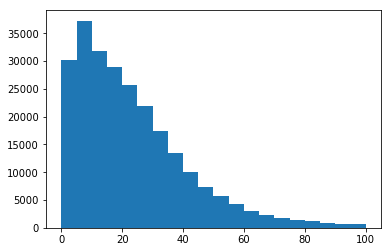

In [38]:
plt.hist(weird_df.length, range = [0, 100], bins = 20 )

(array([ 59319.,  47065.,  38658.,  31605.,  23418.,  16055.,  10378.,
          7029.,   4597.,   3044.,   1978.,   1357.,   1018.,    739.,
           514.,    338.,    267.,    198.,    142.,    150.]),
 array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,
         33.,  36.,  39.,  42.,  45.,  48.,  51.,  54.,  57.,  60.]),
 <a list of 20 Patch objects>)

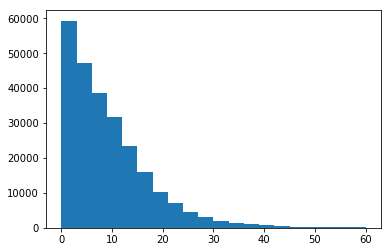

In [39]:
plt.hist(weird_df.k_important, range = [0, 60], bins = 20 )

(array([ 67021.,  36694.,  31565.,  27254.,  22292.,  17263.,  13069.,
          9369.,   6739.,   4848.,   3402.,   2420.,   1705.,   1207.,
           859.,    659.,    456.,    362.,    255.,    335.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]),
 <a list of 20 Patch objects>)

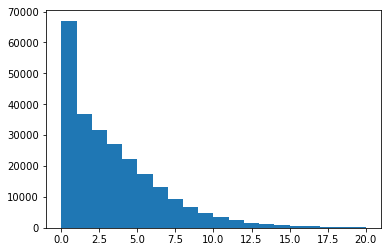

In [40]:
plt.hist(weird_df.verbs, range = [0, 20], bins = 20 )

(array([ 71469.,  50852.,  41268.,  30119.,  20055.,  12298.,   7825.,
          4808.,   2993.,   1947.,   1308.,    884.,    647.,    427.,
           303.,    234.,    171.,    118.,    110.,    125.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.]),
 <a list of 20 Patch objects>)

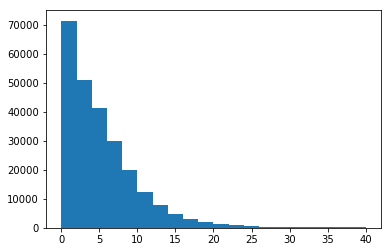

In [41]:
plt.hist(weird_df.nouns, range = [0, 40], bins = 20 )

(array([ 11129.,  11722.,  12653.,  13901.,  14371.,  14598.,  14940.,
         14638.,  14809.,  14580.,  14473.,  13939.,  12989.,  12647.,
         11496.,  10650.,   9479.,   8673.,   8382.,   8241.]),
 array([   0.        ,    5.00531067,   10.01062135,   15.01593202,
          20.0212427 ,   25.02655337,   30.03186405,   35.03717472,
          40.0424854 ,   45.04779607,   50.05310674,   55.05841742,
          60.06372809,   65.06903877,   70.07434944,   75.07966012,
          80.08497079,   85.09028147,   90.09559214,   95.10090281,
         100.10621349]),
 <a list of 20 Patch objects>)

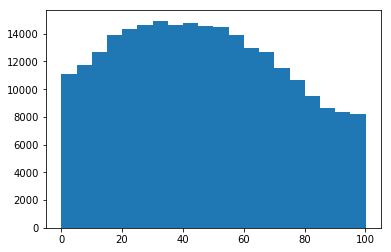

In [42]:
plt.hist(weird_df.position, bins = 20 )

We have a clear difference in distribution of the features: for the abstracts, we get a more or less normal distribution for all features, for the probably non-abstract sentences, we get skewed distributions, as expected:
* examples are short
* contain non-english words (not tagged by POS tagger)
* less important words

I will eliminate the probably non-sentences from both dataframes. Randomly select about 20 000 sentences from df_weird for classification.

In [186]:
abstract_trash = list(df_trash_abstract.index)
abstracts_clean = features_df.iloc[[n for n in list(features_df.index) if n not in abstract_trash]]

In [187]:
abstracts_clean.shape

(18383, 9)

In [180]:
weird_trash = list(df_trash_weird.index)
weird_clean = weird_df.iloc[[n for n in list(weird_df.index) if n not in weird_trash]]

In [189]:
weird_clean.tail()

,sentence,length,named_entities,k_important,position,upper,nouns,verbs,adjectives,category
248274,deaf-NU-INF (Pol) b. Moje koty cats-NOM b˛...,23,0,2,66.847826,14,3,1,1,0
248275,My cats will be deaf.’ ogłuch-ł-e.,12,0,0,67.119565,4,1,2,1,0
248276,The ﬁrst one involved a case where a lexical e...,41,2,20,68.206522,3,11,5,6,0
248277,This ultimately accounts for the contrast betw...,39,1,14,68.750000,5,7,5,6,0
248308,"Preﬁx stacking, syncretism, and the syntactic ...",10,0,4,98.913043,3,2,1,1,0


Add class, join dataframes, normalize (in order for every feature to be equally important)

In [188]:
abstracts_clean['category'] = 1

/home/aleksandra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [182]:
weird_clean['category'] = 0

/home/aleksandra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [183]:
weird_clean_sample = weird_clean.sample(19000)

In [184]:
weird_clean_sample.tail()

,sentence,length,named_entities,k_important,position,upper,nouns,verbs,adjectives,category
32441,presents’. This lexical item belongs to ...,29,0,6,47.471300,17,5,1,1,0
39594,"Like direct objects, instrumental objects in a...",39,0,15,62.398240,8,8,6,3,0
42531,Table 29 Logistic Regression Results – Experi...,148,6,39,54.012868,134,5,1,2,0
68367,", the argument arrangement) remaining the sa...",92,5,18,63.627924,40,13,5,3,0
20707,3-CL-or.more-GEN student-NOM gather-NE...,40,0,9,61.426979,19,8,1,3,0


In [190]:
all_sentences = pd.concat([abstracts_clean, weird_clean_sample])

In [191]:
all_sentences.describe()

,length,named_entities,k_important,position,upper,nouns,verbs,adjectives,category
count,37383.000000,37383.000000,37383.000000,37383.000000,37383.000000,37383.000000,37383.000000,37383.000000,37383.000000
mean,38.151673,1.228152,12.366343,41.918128,12.977958,6.378675,4.124147,2.922585,0.491748
std,28.621943,1.557651,8.154181,26.674856,17.877021,4.693379,2.890956,2.531203,0.499939
min,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,21.000000,0.000000,7.000000,20.000000,4.000000,3.000000,2.000000,1.000000,0.000000
50%,31.000000,1.000000,11.000000,41.163793,8.000000,6.000000,3.000000,2.000000,0.000000
75%,46.000000,2.000000,16.000000,63.636364,15.000000,8.000000,5.000000,4.000000,1.000000
max,1260.000000,30.000000,313.000000,99.965870,1086.000000,140.000000,52.000000,37.000000,1.000000


In [192]:
all_sentences2 = all_sentences[all_sentences.length < 300]

In [193]:
all_sentences2.describe()

,length,named_entities,k_important,position,upper,nouns,verbs,adjectives,category
count,37361.000000,37361.000000,37361.000000,37361.000000,37361.000000,37361.000000,37361.000000,37361.000000,37361.000000
mean,37.924279,1.222960,12.331817,41.913162,12.805118,6.357003,4.117475,2.918418,0.492037
std,26.614869,1.531999,7.899098,26.672054,15.680738,4.557503,2.860241,2.517781,0.499943
min,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,21.000000,0.000000,7.000000,20.000000,4.000000,3.000000,2.000000,1.000000,0.000000
50%,31.000000,1.000000,11.000000,41.144114,8.000000,6.000000,3.000000,2.000000,0.000000
75%,46.000000,2.000000,16.000000,63.636364,15.000000,8.000000,5.000000,4.000000,1.000000
max,298.000000,30.000000,96.000000,99.965870,241.000000,95.000000,34.000000,37.000000,1.000000


In [195]:
joblib.dump(all_sentences2, 'data_classification')

['data_classification']